# Using MAPE loss function and Powel method builded custom polynomial regression functiion using pipiline(polynomial features - custom linear rergession)
# In objective function added L2 regularization
# Polynom degree choose by cross validation

In [5]:
import numpy as np
from sklearn import datasets

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
plt.rcParams['figure.figsize'] = [20,8]

## Get data

In [7]:
# Generate nonlinear data with outliers.
# Don't hesitate to change the generation parameters, method and data itself! Observe, how it changes results

n_samples = 1000
n_outliers = 100

X, y, coef = datasets.make_regression(n_samples=n_samples, n_features=1,
                                      n_informative=1, noise=25,
                                      coef=True, random_state=1110)

In [8]:
print(X.shape, y.shape)

(1000, 1) (1000,)


In [9]:
# Replace first N samples with outliers

X[:n_outliers] = np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = 100 * np.random.normal(size=n_outliers)

In [10]:
# Add non-linearity to data

y = y+100*X.T[0]*np.sin(X.T[0])

In [11]:
# Scale data to put in range [0,1] for stability.
# Check results if ignore it.
# See also sklearn User Guide (https://scikit-learn.org/stable/modules/preprocessing.html#scaling-features-to-a-range) and try another tools (Standartization, Normalization)
X = (X - X.min())/(X.max()-X.min())
y = (y - y.min())/(y.max()-y.min())

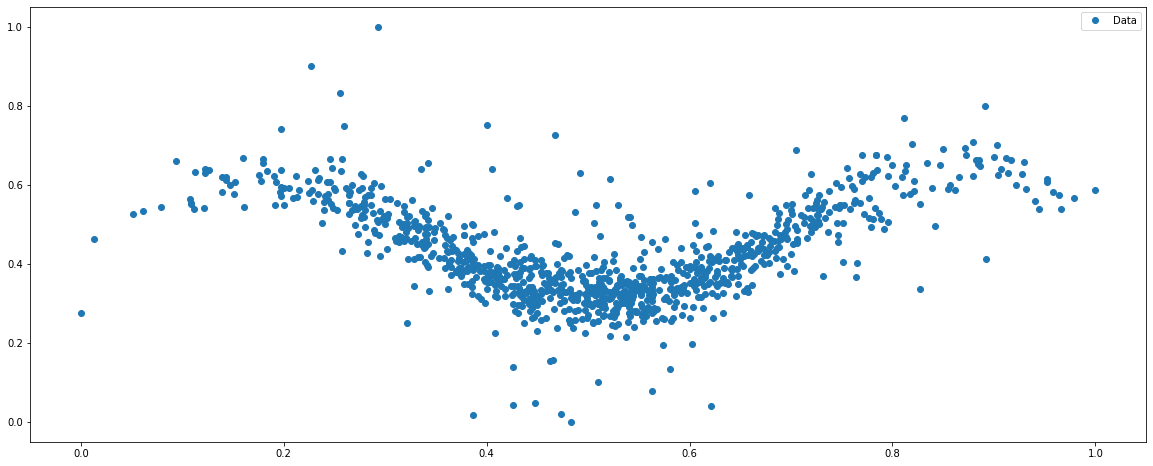

In [12]:
#visualize data
plt.plot(X, y, 'o', label = 'Data')
plt.legend()

In [13]:
# Add bias column to data
X_I = np.c_[np.ones_like(X), X]

# Loss function - MAPE 
for more information see HW-2-diff-loss-func-and-opt-methods

In [14]:
def mape(y_true, y_pred):
    y_true = np.asanyarray(y_true)
    y_pred = np.asanyarray(y_pred)
    assert len(y_true) == len(y_pred), "Target and Prediction arrays length should be equal"
    
    if np.any(y_true==0):
        #print("Found zeroes in y_true. MAPE is undefined. Removing it from set.")
        idx = np.where(y_true==0)
        y_true = np.delete(y_true, idx)
        y_pred = np.delete(y_pred, idx)
        #print("%i samples deleted" %len(idx))
    
    mape_value = np.mean(np.abs((y_true - y_pred) / y_true))*100
    return mape_value

### Define predict model
Prediction function $h(\theta|X) = \theta^Tx$:

In [15]:
def predict(X, theta):
    return np.dot(X, theta)

# Define objective (goal) function as simple as
$L(\theta|X,y) = MAPE(y, h(\theta|X))+ (lamda / (2*len(y) )) * np.sum(np.square(theta))$

To make it compatible with optimization procedure, put optimizied parameter _theta_ on the first place in arguments. 

In [22]:
def l1_penalty(theta,lamda):
    return (lamda) * np.sum(np.abs(theta))

In [23]:
def l2_penalty(theta,lamda):
    return (lamda) * np.sum(np.square(theta))

In [24]:
def elastic_net(theta, lamdas):
    lamda1 = lamdas[0]
    lamda2 = lamdas[1]
    return l1_penalty(theta,lamda1)+l2_penalty(theta,lamda2)

In [25]:
def objective_function(theta, X,y, lamdas, loss_function=mape, penalty=elastic_net):
  y_true = np.asanyarray(y)
  y_pred = predict(X, theta)
  
  return loss_function(y_true, y_pred)+ penalty(theta, lamdas)

# Visualize objective function surface

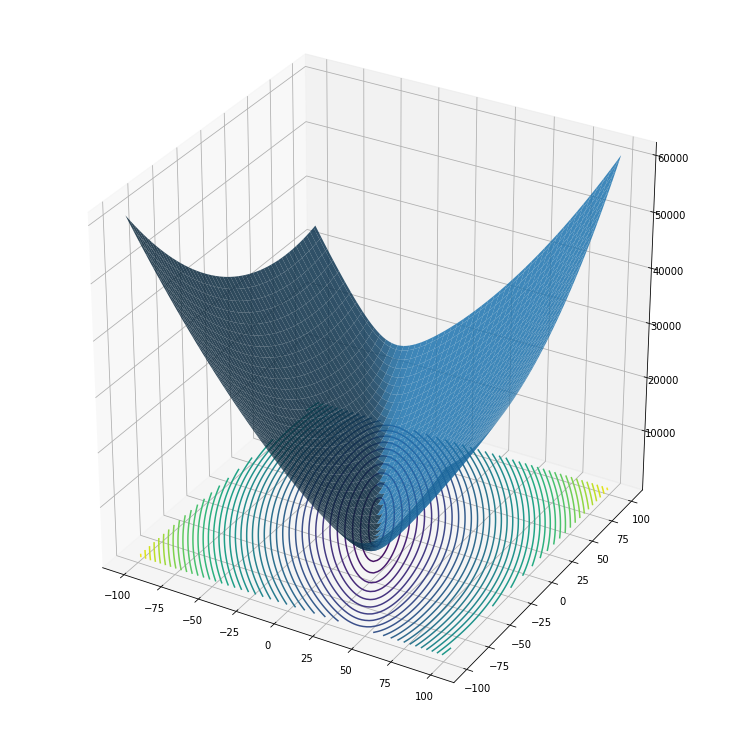

In [26]:
size = 100 # amount of tries for each parameter
limits = (-100,100) # range of values for each parameter
error = np.zeros((size,size)) # empty matrix of errors
for i,w in enumerate(np.linspace(*limits,size)): # for each theta[0] component
    for j,b in enumerate(np.linspace(*limits,size)): # for each theate[1] component
        error[i,j] = objective_function(np.array([b,w]), X_I, y,[1,1], mape) # compute cost for each theta

# initialize figure
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (10,10))
ax = Axes3D(fig)

# create 2d array for each index 
K,L = np.meshgrid(np.linspace(*limits,size),np.linspace(*limits,size))

ax.plot_surface(K,L,Z = error, alpha = 0.85) # plot cost function surface in 3d
plt.contour(K,L,error,50, offset = 1) # plot cost function 2d-projection

## Train model by Powel method using scipy.optimize

In [27]:
from scipy import optimize

lamda = 0

In [28]:
theta_init = np.array([1]*X_I.shape[1]) # initial value of theta

result = optimize.minimize(
                           objective_function,  # function to optimize. Parameter to optimize should the first argument 
                           args=(X_I, y, [0,0], mape, elastic_net), # other arguments of the function
                           x0 = theta_init,     # initial value of parameter to optimize
                           method='Powell',     # optimization method. Try also BFGS, Nelder-Mead, Powell, CG, TNC and others (see docs). Effectivnes can change dramatically!
                           options={}           # arguments of optimization method, like number of iterations, learning rate, etc.
                           )

In [29]:
without_regul_fun = result.fun
without_regul_theta = result.x
print('Optimization result:', ['FAIL','Success'][result.success])
print('Comment:', result.message)
print('Objective function value:', without_regul_fun)
print('Found theta:', without_regul_theta)


Optimization result: Success
Comment: Optimization terminated successfully.
Objective function value: 27.874073686009005
Found theta: [ 0.3656893  -0.00529907]


# For further use, let's make universal function to train regression model with any objective and loss functions

In [38]:
def custom_regression(X, y, lamdas,
                      objective_function=objective_function, 
                      loss_function=mape, 
                      init = 1, 
                      verbose = True, 
                      iters = 100, penalty = elastic_net):
  
    theta_init = np.ones_like(X[0]) * init
    result = optimize.minimize(objective_function,
                             args=(X, y,lamdas, loss_function, penalty), 
                             x0 = theta_init, 
                             method='Powell', 
                             options={'maxiter': iters})
    theta = result['x']
    if verbose:
        print(result['fun'])
    return theta

## Add polynomial features

In [39]:
from sklearn.preprocessing import PolynomialFeatures

n = 10 # power of polynom
polynomial_features = PolynomialFeatures(degree=n,include_bias=True) # create instance of preprocessor
X_a = polynomial_features.fit_transform(X) # apply transformation
X_a.shape

(1000, 11)

In [40]:
theta = custom_regression(X_a, y,[1,1], objective_function=objective_function, loss_function=mape, penalty=elastic_net)
theta

25.41681912417724


array([ 5.37654152e-01, -4.79585095e-01, -5.84386150e-07,  1.66559462e-01,
        2.86019872e-01,  3.10395082e-01,  1.55427477e-01, -2.59736906e-09,
       -2.22365155e-09,  1.78138880e-09, -3.63672148e-06])

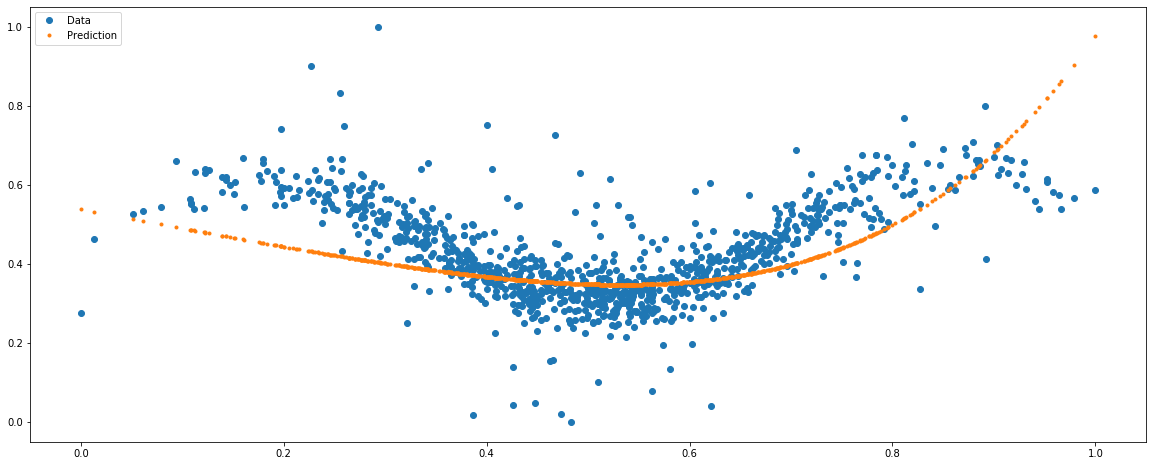

In [41]:
y_pred = predict(X_a, theta)
plt.plot(X, y, 'o', label = 'Data')
ax = plt.gca()
ax.autoscale(enable = True)
plt.plot(X, y_pred, '.', label = 'Prediction')
plt.legend()

# Visually difficult to undestend if polynom with power 10 good or bad for our data, choosen optimization method and loss. For first evaluating we will use splitting data on train adn test to see how our model behave on data that it didn't see before using train and test score

In [42]:
from sklearn.model_selection import train_test_split

# Split data to test and train in sklearn style
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

PolynomialFeatures(degree=10 

In [47]:
results = {}
lamdas = [1,1]
polynomial_features = PolynomialFeatures(degree=10,include_bias=True) # create instance of preprocessor

X_a_train = polynomial_features.fit_transform(X_train)
X_a_test = polynomial_features.fit_transform(X_test)

theta = custom_regression(X_a, y,lamdas, objective_function=objective_function, loss_function=mape, penalty = elastic_net)

test_score = objective_function(theta=theta, X=X_a_test, y=y_test, lamdas=lamdas)
train_score = objective_function(theta=theta, X=X_a_train, y=y_train, lamdas=lamdas)
results[0] ={'test_score':test_score, 'train_score':train_score}

25.41681912417724


In [48]:
import pandas as pd
results = pd.DataFrame(results).T
results.style

,test_score,train_score
0,25.746069,25.254409


Let's use different lamdas

# For estimating lamda for regularization and for better generalization we need to do cross validation

To make convenient and safe using of our approach (preprocessing + modelling) we can use great sklearn tool called [Pipelines](https://scikit-learn.org/stable/modules/compose.html#pipelines-and-composite-estimators).

Pipeline can include any number of data transformations and modelling, and than be treated as a single sklearn object.

To make it possible, all models of sklearn inherits the same interface, which essentialy should have just few methods:
* ```__init__()```, that should be able to be called without arguments and create an instance with no dependencies to data.
* ```fit()```, that takes data and make all data-dependent actions (transformations or training). Main logic is here. 
* ```predict()``` (for models) or ```transform()``` (for preprocessing) to process a new data after fitted

Optionally, we can use ```score()``` which take true data and return single value to evaluate quality of the model. It is used to make cross-validation and other model selection procedures.

Finally, methods ```fit_transform()``` or ```fit_predict()``` are not essential, but commonly used and just make fit and transform (or predict) on the same data data in one step.




In [53]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, RegressorMixin 

Sklearn has one basic class ```BaseEstimator``` for all objects and few inherited specials for particular tasks, like ```ClassifierMixin```, ```RegressorMixin``` and ```TransformerMixin```. Inheriting them we can be sure that we have all non-essential but useful methods, like ```set_value```, ```get_value``` etc, and also tell Pipelines how to treat our object.

In [54]:
class CustomRegression(BaseEstimator, RegressorMixin):                           
  def __init__(self, loss_function=mape, objective_function=objective_function, lamdas=[0,0]): # all arguments should have default values
    self.theta = None # we don't know shape of theta on this stage
    # just save all variables taken during call to internal variables
    self.loss_function = loss_function 
    self.objective_function = objective_function
    self.lamdas = lamdas
    
  def predict(self, X):
    return predict(X, self.theta)
  
  def score(self, X, y):
    return self.objective_function(theta=self.theta, X=X,y=y,lamdas=self.lamdas,loss_function=self.loss_function)
  
  def fit(self, X, y):
    if type(self.theta) == type(None):
      self.theta = np.ones_like(X[0])
    else:
      assert self.theta.shape == X[0].shape, "Model's shape doesn't fit input shape"
    self.theta = custom_regression(X, y, self.lamdas, self.objective_function, self.loss_function, verbose = False)
    return self.score(X, y)
  
  def fit_predict(self, X, y):
    self.fit(X,y)
    return self.predict(X)
     

In [55]:
%%time
results = {}
row_results = {}
for i,n in enumerate(lamda_list):
  polynomial_features = PolynomialFeatures(degree = 10, include_bias=True) # create instance of transformer
  regression = CustomRegression(lamda=n) # create instance of model
    
  # make pipeline as list of pairs (<stage name>, <stage object>):
  pipeline = Pipeline([("polynomial_features", polynomial_features), # augment data
                       ("linear_regression", regression)]) # apply linear regression

  # Evaluate pipeline using crossvalidation and score() method
  scores = cross_val_score(pipeline, X_train, y_train, cv=10)
    
  pipeline.fit(X_train, y_train)
  # Make single evaluation on test set
  test_scores = pipeline.score(X_test, y_test)

  # Save results
  results[n] = {'CV_mean':scores.mean(), 'CV_std':scores.std(), 'Test':test_scores}
  row_results[n] = scores

  # Plot results
  line_x = np.linspace(-0.1, 1.1, 1000).reshape(1000,1)
  line_y = pipeline.predict(line_x)
  
  ax = plt.subplot(1, len(lamda_list), i + 1)
  ax.plot(X, y, '.', alpha = 0.5, label = 'Data')
  ax.autoscale(enable = False)
  ax.plot(line_x, line_y, '-', label = 'Prediction')
  plt.title("Lamda %i\nCV-Score: %.2f +- %.2f\nTest-Score: %.2f"%(n, results[n]['CV_mean'],results[n]['CV_std'],results[n]['Test']))
  
plt.legend()

NameError: name 'lamda_list' is not defined

In [68]:
results = pd.DataFrame(results).T
results.style.highlight_min()

,CV_mean,CV_std,Test
0.0,11.888645,1.891898,12.080582
0.1,13.059540,1.656881,13.567607
0.2,13.834628,1.690749,15.252221
0.30000000000000004,14.373667,1.603700,15.071759
0.4,14.968071,1.549414,15.308060
0.5,15.335707,1.559060,15.791284
0.6000000000000001,15.697057,1.582156,16.288625
0.7000000000000001,15.981919,1.561144,16.578885
0.8,16.192029,1.586667,16.980769
0.9,16.400607,1.608334,17.341495


In [58]:
%%time
results = {}
row_results = {}
lamdas_list =((0,0), (0,1), (1,0), (1,1))
for i,n in enumerate(lamdas_list):
  polynomial_features = PolynomialFeatures(degree = 10, include_bias=True) # create instance of transformer
  regression = CustomRegression(lamdas=n) # create instance of model
    
  # make pipeline as list of pairs (<stage name>, <stage object>):
  pipeline = Pipeline([("polynomial_features", polynomial_features), # augment data
                       ("linear_regression", regression)]) # apply linear regression

  # Evaluate pipeline using crossvalidation and score() method
  scores = cross_val_score(pipeline, X_train, y_train, cv=10)
    
  pipeline.fit(X_train, y_train)
  # Make single evaluation on test set
  test_scores = pipeline.score(X_test, y_test)

  # Save results
  results[n] = {'CV_mean':scores.mean(), 'CV_std':scores.std(), 'Test':test_scores}
  row_results[n] = scores


Wall time: 12.5 s


In [80]:
np.logspace(-10, 1, 10)[2]

2.782559402207126e-08

In [59]:
results = pd.DataFrame(results).T
results.style.highlight_min()

# again we don`t need to use regularization if we used polynomial feature engineering